<a href="https://colab.research.google.com/github/BenzThitikorn/Vector-Symbol-Decoding-with-AI/blob/main/Machine_learning_with%20test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# --- 1.Set Up Environment ---

In [1]:
# prompt: clear system ram and gpu ram

import gc
import torch

# Clear RAM
gc.collect()
torch.cuda.empty_cache()


In [2]:
!git clone https://github.com/BenzThitikorn/Vector-Symbol-Decoding-with-AI.git
!pip install --upgrade pyldpc
!pip install livelossplot

Cloning into 'Vector-Symbol-Decoding-with-AI'...
remote: Enumerating objects: 11796, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 11796 (delta 25), reused 32 (delta 5), pack-reused 11729 (from 2)
Receiving objects: 100% (11796/11796), 58.79 MiB | 14.37 MiB/s, done.
Resolving deltas: 100% (673/673), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyldpc: filename=pyldpc-0.7.9-py3-none-any.whl size=14303 sha256=ef7c685f39968df1f96e9a75c8b48aaae2049564ea288a18a7e6dcf67b6d819a
  Stored in directory: /root/.cache/pip/wheels/64/94/ad/d9f332bc2a1e857f54fe35b124d59d27d681f37a0e15b7b027
Successfully built pyldpc


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

Using cuda device


## --- Import Data to train ---

In [5]:
from pyldpc import make_ldpc

d_v = 3  # Variable node degree
d_c = 6  # Check node degree
n = 30 #Code lenght
r = 32 #Symbol lenght
H, Gt = make_ldpc(n, d_v=d_v, d_c=d_c, systematic=True, sparse=True, seed=1)
G = Gt.T  # Transpose of Gt to get G
j = G.shape[0]  # Number of rows in G
print(f"H matrix: {H.shape[0]} rows, {H.shape[1]} columns")
print(f"G matrix: {G.shape[0]} rows, {G.shape[1]} columns")


H matrix: 15 rows, 30 columns
G matrix: 17 rows, 30 columns


In [6]:
import numpy as np
X = np.load('/content/drive/MyDrive/Training Data/LDPC(15,30) /32 bits/X.npy')
Y = np.load('/content/drive/MyDrive/Training Data/LDPC(15,30) /32 bits/Y.npy')
#X = np.concatenate((X, np.load('')), axis=axis)
#Y = np.concatenate((Y, matrix2), axis=axis)

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y^1, train_size= 0.85)


from pyldpc import make_ldpc

d_v = 3  # Variable node degree
d_c = 6  # Check node degree
n = 30 #Code lenght
r = 16 #Symbol lenght
H, Gt = make_ldpc(n, d_v=d_v, d_c=d_c, systematic=True, sparse=True, seed=1)
G = Gt.T  # Transpose of Gt to get G
j = G.shape[0]  # Number of rows in G
print(f"H matrix: {H.shape[0]} rows, {H.shape[1]} columns")
print(f"G matrix: {G.shape[0]} rows, {G.shape[1]} columns")


H matrix: 15 rows, 30 columns
G matrix: 17 rows, 30 columns


# Train

In [7]:
def update_model(model, loss_fn, opt, train_loader):
    train_loss = 0
    train_correct = 0
    train_count = len(train_loader.dataset)

    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)

        predicted = (y_pred > 0.5).float()
        # Increment train_correct by 1 for each sample where all predicted bits match y
        train_correct += torch.all(predicted == y, dim=1).sum().item()

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() * len(y)

        opt.zero_grad()
        loss.backward()
        opt.step()

    mean_train_loss = train_loss / train_count
    train_accuracy = train_correct / train_count
    return mean_train_loss, train_accuracy

def evaluate_model(model, loss_fn, dataloader):
    model.eval()

    valid_loss = 0
    valid_correct = 0
    valid_count = len(dataloader.dataset)

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)

        predicted = (y_pred > 0.5).float()
        # Same logic for validation
        valid_correct += torch.all(predicted == y, dim=1).sum().item()

        loss = loss_fn(y_pred, y)
        valid_loss += loss.item() * len(y)

    mean_valid_loss = valid_loss / valid_count
    valid_accuracy = valid_correct / valid_count
    model.train()
    return mean_valid_loss, valid_accuracy

def train(model, loss_fn, opt, train_loader, valid_loader, epoch, scheduler=None, verbose=True):
    if verbose:
        liveloss = PlotLosses()

    for i in range(epoch):
        # Update the model using the training data
        train_loss, train_accuracy = update_model(model, loss_fn, opt, train_loader)

        # Evaluate the model using the validation data
        valid_loss, valid_accuracy = evaluate_model(model, loss_fn, valid_loader)

        # Update the learning rate scheduler (if provided)
        if scheduler:
            scheduler.step()  # This step adjusts the learning rate according to the scheduler

        if verbose:
            # Update live loss plot
            liveloss.update({
                'loss': train_loss,
                'val_loss': valid_loss,
                'accuracy': train_accuracy,
                'val_accuracy': valid_accuracy,
            })
            liveloss.draw()

    if verbose:
        print('Accuracy: {:.4f} (valid), {:.4f} (train)'.format(valid_accuracy, train_accuracy))

    return model


In [8]:
from torch.optim import Adam,AdamW
from torch.optim.lr_scheduler import StepLR

X_train_flatten = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_valid_flatten = X_valid.reshape(X_valid.shape[0], X_valid.shape[1]*X_valid.shape[2])

X_train_torch = torch.tensor(X_train_flatten, dtype=torch.float) # Don't forget dtype=torch.float
X_valid_torch = torch.tensor(X_valid_flatten, dtype=torch.float)

Y_train_torch = torch.tensor(Y_train, dtype=torch.float) # Don't forget dtype=torch.long
Y_valid_torch = torch.tensor(Y_valid, dtype=torch.float)

train_dataset = torch.utils.data.TensorDataset(X_train_torch, Y_train_torch)
valid_dataset = torch.utils.data.TensorDataset(X_valid_torch, Y_valid_torch)

In [11]:
from torch.utils.data import DataLoader

batch_size = 2056  # Adjust based on available GPU memory

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    pin_memory=True, num_workers=6, prefetch_factor=2
)

valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False,
    pin_memory=True, num_workers=6, prefetch_factor=2
)

input_size = X_train_flatten.shape[1]
output_size = Y_train_torch.shape[1]

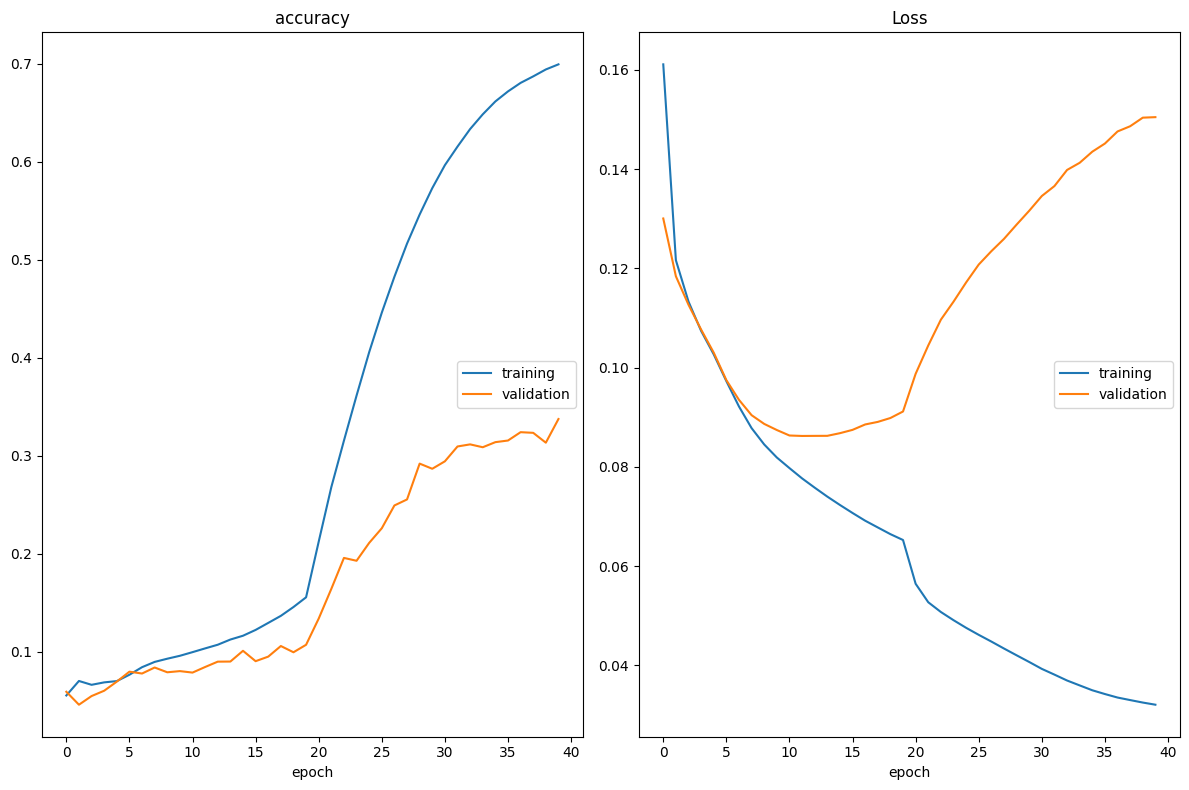

accuracy
	training         	 (min:    0.055, max:    0.699, cur:    0.699)
	validation       	 (min:    0.046, max:    0.337, cur:    0.337)
Loss
	training         	 (min:    0.032, max:    0.161, cur:    0.032)
	validation       	 (min:    0.086, max:    0.150, cur:    0.150)
Accuracy: 0.3374 (valid), 0.6991 (train)


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from livelossplot import PlotLosses

#Model 1
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

model_1 = torch.nn.Sequential(
    nn.Linear(input_size, 2048),  # Increase layer size
    nn.Sigmoid(),
    nn.BatchNorm1d(2048),
    #nn.Dropout(0.3),  # Add dropout
    nn.Linear(2048, 1024),
    nn.PReLU(),
    nn.BatchNorm1d(1024),
    #nn.Dropout(0.3),
    nn.Linear(1024, 1024),
    nn.PReLU(),
    nn.BatchNorm1d(1024),
    #nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.PReLU(),
    nn.BatchNorm1d(512),
    #nn.Dropout(0.3),
    nn.Linear(512, output_size),
).to(device)

# Prepare loss functions and optimization methods
loss_fn = nn.BCEWithLogitsLoss()
optimizer = AdamW(model_1.parameters(), lr=0.01, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma = 0.5)

trained_model = train(model_1, loss_fn, optimizer, train_loader, valid_loader, epoch=40, scheduler=scheduler)

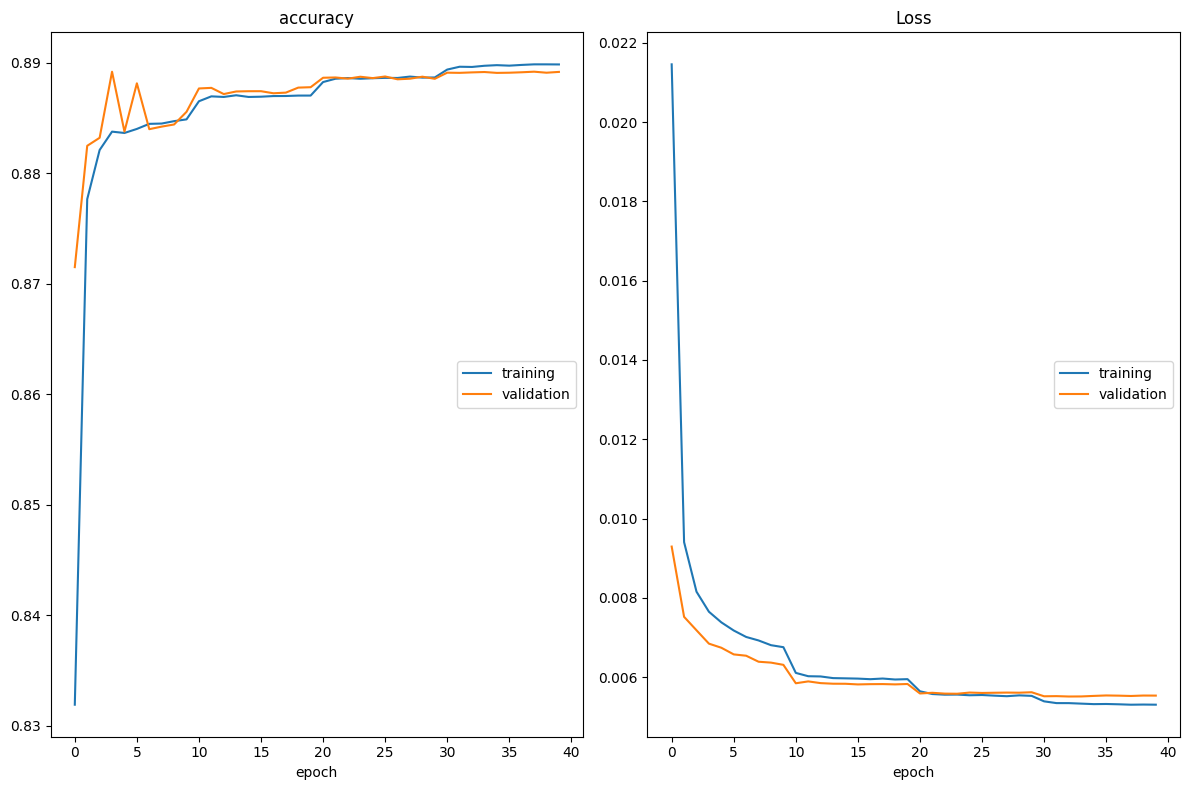

accuracy
	training         	 (min:    0.832, max:    0.890, cur:    0.890)
	validation       	 (min:    0.872, max:    0.889, cur:    0.889)
Loss
	training         	 (min:    0.005, max:    0.021, cur:    0.005)
	validation       	 (min:    0.006, max:    0.009, cur:    0.006)
Accuracy: 0.8892 (valid), 0.8899 (train)


In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from livelossplot import PlotLosses

#Model 2
#torch.manual_seed(0)
torch.backends.cudnn.deterministic = False

model_2 = torch.nn.Sequential(
    nn.Linear(input_size, 1024),
    nn.GELU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.GELU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    #nn.Dropout(0.2),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, output_size),
).to(device)


# Prepare loss functions and optimization methods
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = AdamW(model_2.parameters(), lr=0.01, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma = 0.5)

trained_model = train(model_2, loss_fn, optimizer, train_loader, valid_loader, epoch=40, scheduler=scheduler)

In [57]:
torch.save(model_2.state_dict(), '/content/drive/MyDrive/Training Data/LDPC(15,30) /32 bits/model_2.pth')


# Test here

In [16]:
import torch
import Channel_Coding as cc
def hamming_loss(y_true, y_pred):
    """
    Calculate the Hamming loss between the true labels and the predicted labels.

    Parameters:
    y_true (torch.Tensor): True binary labels of shape (n_samples, n_labels)
    y_pred (torch.Tensor): Predicted binary labels of shape (n_samples, n_labels)

    Returns:
    float: Hamming loss
    """
    assert y_true.shape == y_pred.shape, "Shape of y_true and y_pred must be the same"

    # Convert predictions to binary (0 or 1)
    y_pred_binary = (y_pred > 0.5).float()

    # Calculate the number of incorrect labels
    incorrect_labels = (y_true != y_pred_binary).float().sum()

    # Calculate the total number of labels
    total_labels = y_true.numel()

    # Calculate Hamming loss
    hamming_loss_value = incorrect_labels / total_labels

    return hamming_loss_value.item()

# Example usage
y_true = torch.tensor([[1, 0, 1], [0, 1, 0]], dtype=torch.float32)
y_pred = torch.tensor([[0.8, 0.2, 0.6], [0.4, 0.7, 0.3]], dtype=torch.float32)

loss = hamming_loss(y_true, y_pred)
print(f"Hamming Loss: {loss}")


Hamming Loss: 0.0


  9%|▉         | 1/11 [00:01<00:13,  1.33s/it]

SER = 0.00:
VSD normal: 500 successes from 500 trials (100.00%)
VSD with AI: 500 successes from 500 trials (100.00%)
VSD combined: 500 successes from 500 trials (100.00%)
hMP: 500 successes from 500 trials (100.00%)
--------------------------------------------------


 18%|█▊        | 2/11 [00:03<00:16,  1.82s/it]

SER = 0.05:
VSD normal: 440 successes from 500 trials (88.00%)
VSD with AI: 446 successes from 500 trials (89.20%)
VSD combined: 455 successes from 500 trials (91.00%)
hMP: 440 successes from 500 trials (88.00%)
--------------------------------------------------


 27%|██▋       | 3/11 [00:06<00:18,  2.29s/it]

SER = 0.10:
VSD normal: 403 successes from 500 trials (80.60%)
VSD with AI: 350 successes from 500 trials (70.00%)
VSD combined: 412 successes from 500 trials (82.40%)
hMP: 395 successes from 500 trials (79.00%)
--------------------------------------------------


 36%|███▋      | 4/11 [00:10<00:20,  2.86s/it]

SER = 0.15:
VSD normal: 281 successes from 500 trials (56.20%)
VSD with AI: 214 successes from 500 trials (42.80%)
VSD combined: 292 successes from 500 trials (58.40%)
hMP: 268 successes from 500 trials (53.60%)
--------------------------------------------------


 45%|████▌     | 5/11 [00:14<00:20,  3.43s/it]

SER = 0.20:
VSD normal: 224 successes from 500 trials (44.80%)
VSD with AI: 111 successes from 500 trials (22.20%)
VSD combined: 231 successes from 500 trials (46.20%)
hMP: 202 successes from 500 trials (40.40%)
--------------------------------------------------


 55%|█████▍    | 6/11 [00:19<00:20,  4.03s/it]

SER = 0.25:
VSD normal: 134 successes from 500 trials (26.80%)
VSD with AI: 45 successes from 500 trials (9.00%)
VSD combined: 138 successes from 500 trials (27.60%)
hMP: 103 successes from 500 trials (20.60%)
--------------------------------------------------


 64%|██████▎   | 7/11 [00:25<00:18,  4.69s/it]

SER = 0.30:
VSD normal: 85 successes from 500 trials (17.00%)
VSD with AI: 31 successes from 500 trials (6.20%)
VSD combined: 89 successes from 500 trials (17.80%)
hMP: 54 successes from 500 trials (10.80%)
--------------------------------------------------


 73%|███████▎  | 8/11 [00:32<00:16,  5.34s/it]

SER = 0.35:
VSD normal: 36 successes from 500 trials (7.20%)
VSD with AI: 6 successes from 500 trials (1.20%)
VSD combined: 39 successes from 500 trials (7.80%)
hMP: 15 successes from 500 trials (3.00%)
--------------------------------------------------


 82%|████████▏ | 9/11 [00:39<00:12,  6.01s/it]

SER = 0.40:
VSD normal: 7 successes from 500 trials (1.40%)
VSD with AI: 0 successes from 500 trials (0.00%)
VSD combined: 7 successes from 500 trials (1.40%)
hMP: 4 successes from 500 trials (0.80%)
--------------------------------------------------


 91%|█████████ | 10/11 [00:47<00:06,  6.62s/it]

SER = 0.45:
VSD normal: 7 successes from 500 trials (1.40%)
VSD with AI: 2 successes from 500 trials (0.40%)
VSD combined: 8 successes from 500 trials (1.60%)
hMP: 2 successes from 500 trials (0.40%)
--------------------------------------------------


100%|██████████| 11/11 [00:56<00:00,  5.13s/it]

SER = 0.50:
VSD normal: 0 successes from 500 trials (0.00%)
VSD with AI: 0 successes from 500 trials (0.00%)
VSD combined: 0 successes from 500 trials (0.00%)
hMP: 0 successes from 500 trials (0.00%)
--------------------------------------------------


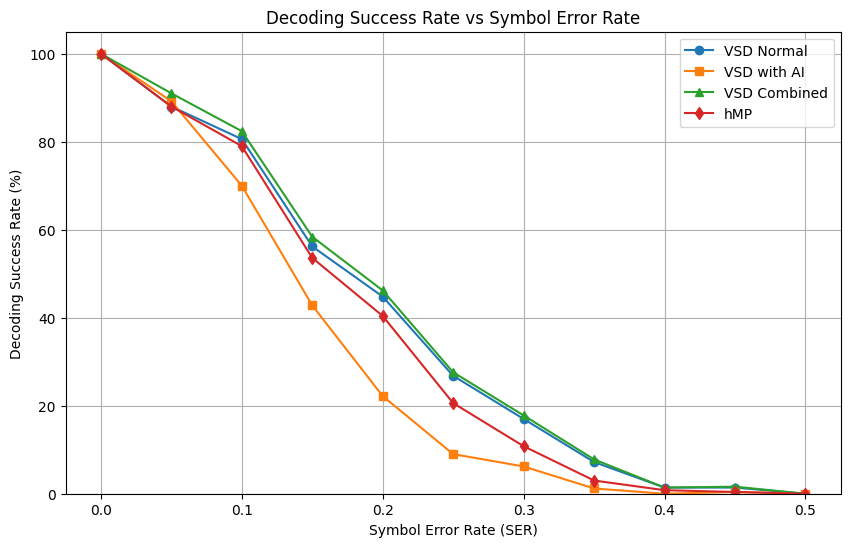

Results successfully plotted and saved as 'ser_comparison.png'


In [55]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random
from tqdm import tqdm  # For progress bar

# Setup SER range to test
ser_values = np.linspace(0, 0.5, 11)  # [0, 0.05, 0.1, ..., 0.5]
success_rates_normal = []
success_rates_ai = []
success_rates_combined = []
success_rates_hMP = []
# Use the existing model
model = model_2
r = 32
num = 500  # Number of trials per SER value

# Loop through each SER value
for SER in tqdm(ser_values):
    total_count_VSD_normal = 0
    total_count_VSD_ai = 0
    total_count_VSD_combined = 0
    total_count_hMP = 0

    for i in range(num):
        error_positions = q_ary_error_channel(SER, n)  # Generate error positions
        message = np.random.randint(0, 2, (r, j))  # Generate a random message
        codeword = np.matmul(message, G).astype(np.int8) % 2  # Encode the message
        error = np.zeros_like(codeword)  # Initialize error vector

        # Introduce errors
        if np.sum(error_positions) > 0:  # Only if there are errors
            error[:, error_positions == 1] = sparse_random(r, np.sum(error_positions),
                                                        density=0.5, format='csr',
                                                        dtype=int).toarray() % 2

        Y = (codeword + error) % 2  # Received codeword
        Syndrome = np.dot(H, Y.T) % 2
        Syndrome = torch.tensor(Syndrome, dtype=torch.float16).to(device)
        S = Syndrome.reshape(1, input_size).type(torch.float16).to(device)

        model.eval()  # Disable dropout and batch norm for inference
        model.type(torch.float16)

        with torch.no_grad():  # Disable gradient calculation
            y_pred = model(S)
            error_predict = (y_pred > 0.5).int()
            error_predict = error_predict.cpu().detach().numpy().reshape(-1)
            sigma = (error_predict + 1) % 2

        Y = Y.T  # Transpose Y for decoding

        # Apply different decoding methods
        if cc.VSD(H,Y)[1] == 1:
            total_count_VSD_normal += 1

        if VSD_ai(H, Y)[1] == 1:
            total_count_VSD_ai += 1

        if VSD_combined(H, Y)[1] == 1:
            total_count_VSD_combined += 1
        if cc.hMP_Group_Common(H,cc.MatrixBinary_to_MatrixDec(Y))[1] == 1:
            total_count_hMP += 1

    # Calculate success rates in percentage
    success_rate_normal = (total_count_VSD_normal / num) * 100
    success_rate_ai = (total_count_VSD_ai / num) * 100
    success_rate_combined = (total_count_VSD_combined / num) * 100
    success_rate_hMP = (total_count_hMP / num) * 100

    # Store the success rates
    success_rates_normal.append(success_rate_normal)
    success_rates_ai.append(success_rate_ai)
    success_rates_combined.append(success_rate_combined)
    success_rates_hMP.append(success_rate_hMP)

    print(f"SER = {SER:.2f}:")
    print(f"VSD normal: {total_count_VSD_normal} successes from {num} trials ({success_rate_normal:.2f}%)")
    print(f"VSD with AI: {total_count_VSD_ai} successes from {num} trials ({success_rate_ai:.2f}%)")
    print(f"VSD combined: {total_count_VSD_combined} successes from {num} trials ({success_rate_combined:.2f}%)")
    print(f"hMP: {total_count_hMP} successes from {num} trials ({success_rate_hMP:.2f}%)")
    print("-" * 50)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ser_values, success_rates_normal, 'o-', label='VSD Normal')
plt.plot(ser_values, success_rates_ai, 's-', label='VSD with AI')
plt.plot(ser_values, success_rates_combined, '^-', label='VSD Combined')
plt.plot(ser_values, success_rates_hMP, 'd-', label='hMP')
plt.xlabel('Symbol Error Rate (SER)')
plt.ylabel('Decoding Success Rate (%)')
plt.title('Decoding Success Rate vs Symbol Error Rate')
plt.legend()
plt.grid(True)
plt.ylim(0, 105)  # Set y-axis limit to 0-105%
plt.savefig('ser_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Results successfully plotted and saved as 'ser_comparison.png'")

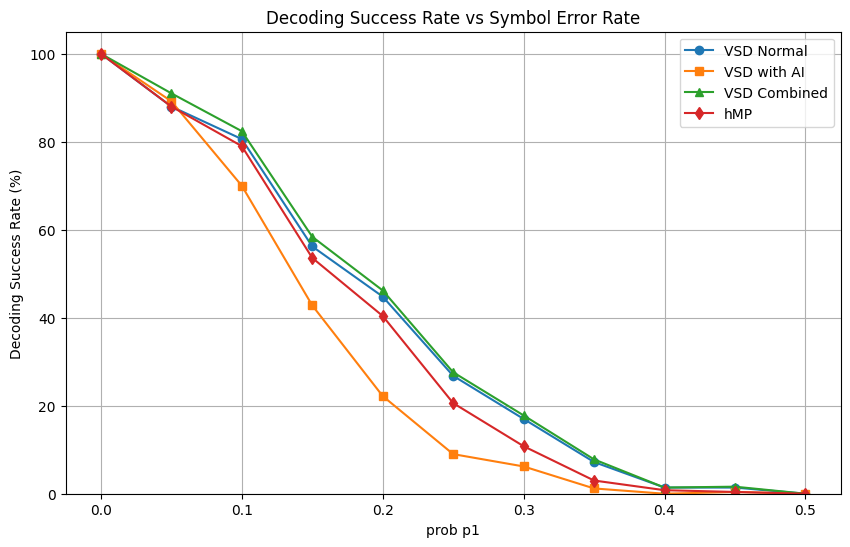

Results successfully plotted and saved as 'ser_comparison.png'


In [59]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ser_values, success_rates_normal, 'o-', label='VSD Normal')
plt.plot(ser_values, success_rates_ai, 's-', label='VSD with AI')
plt.plot(ser_values, success_rates_combined, '^-', label='VSD Combined')
plt.plot(ser_values, success_rates_hMP, 'd-', label='hMP')
plt.xlabel('prob p1')
plt.ylabel('Decoding Success Rate (%)')
plt.title('Decoding Success Rate vs Symbol Error Rate')
plt.legend()
plt.grid(True)
plt.ylim(0, 105)  # Set y-axis limit to 0-105%
plt.savefig('ser_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Results successfully plotted and saved as 'ser_comparison.png'")

In [47]:
def q_ary_error_channel(prob_error,num):
	rng = np.random.default_rng()
	Probability = [1-prob_error, prob_error]
	channel = rng.choice(2, num, p=Probability)
	return channel

def VSD_normal(H, Y):
    Y_Binary = np.array(Y, dtype=int)

    # Compute Syndrome Matrix
    S_Binary = np.floor(np.mod(np.dot(H, Y_Binary), 2)).astype(int)
    S_Gauss, S_rank, Index_Rows = cc.Compute_Gauss_Jordan_Reduction(S_Binary)

    # Compute Error Locating Vector
    Error_Locating_Vector = cc.Compute_Error_Locating_Vector(S_Gauss, Index_Rows, H)

    # Find Number of Erroneous Symbols
    Number_Error = np.count_nonzero(Error_Locating_Vector == 0)

    if Number_Error == 0:
        return Y, 1  # No errors detected

    # Check if Rank of S matches Number of Erroneous Symbols
    if S_rank == Number_Error:
        S_Sub = S_Binary[Index_Rows, :]
        Position_Error = np.where(Error_Locating_Vector == 0)[0]
        H_Sub = H[np.ix_(Index_Rows, Position_Error)]

        # Check if H_Sub is invertible
        if np.linalg.det(H_Sub) == 0:
            #print("normal",H_Sub)
            return Y_Binary, 0  # Cannot correct errors

        H_Sub_inv = np.linalg.inv(H_Sub)
        Error_Binary = np.floor(np.mod(np.dot(H_Sub_inv, S_Sub), 2)).astype(int)

        # Correct the errors
        for index in range(len(Position_Error)):
            Y_Binary[Position_Error[index]] ^= Error_Binary[index]

        Y_decode = Y_Binary  # Decoded output
        #print(H_Sub)
        return Y_decode, 1  # Successful correction
    else:
        return Y_Binary, 0  # Unable to correct errors


def VSD_ai(H, Y):
    Y_Binary = np.array(Y, dtype=int)

    # Compute Syndrome Matrix
    S_Binary = np.floor(np.mod(np.dot(H, Y_Binary), 2)).astype(int)
    S_Gauss, S_rank, Index_Rows = cc.Compute_Gauss_Jordan_Reduction(S_Binary)

    # Ensure `sigma_predict_np` is properly defined before using it
    if 'sigma' not in globals():
        return Y, 0  # Error: `sigma_predict_np` is missing

    # Compute Error Locating Vector
    Error_Locating_Vector = sigma

    # Find Number of Erroneous Symbols
    Number_Error = np.count_nonzero(Error_Locating_Vector == 0)

    if Number_Error == 0:
        return Y, 1  # No errors detected

    # Check if Rank of S matches Number of Erroneous Symbols
    if S_rank == Number_Error:
        S_Sub = S_Binary[Index_Rows, :]
        Position_Error = np.where(Error_Locating_Vector == 0)[0]
        H_Sub = H[np.ix_(Index_Rows, Position_Error)]

        # Check if H_Sub is invertible
        if np.linalg.det(H_Sub) == 0:
            #print("ai",H_Sub)
            return Y, 0  # Cannot correct errors

        H_Sub_inv = np.linalg.inv(H_Sub)
        Error_Binary = np.floor(np.mod(np.dot(H_Sub_inv, S_Sub), 2)).astype(int)

        # Correct the errors
        for index in range(len(Position_Error)):
            Y_Binary[Position_Error[index]] ^= Error_Binary[index]

        Y_decode = Y_Binary  # Decoded output
        return Y_decode, 1  # Successful correction
    else:
        return Y, 0  # Unable to correct errors

def VSD_combined(H, Y):
    result_normal = VSD_normal(H, Y)

    # If VSD_normal fails (error correction unsuccessful), try VSD_ai
    if result_normal[1] == 0:
        return VSD_ai(H, Y)

    return result_normal  # Return the successful result from VSD_normal


def VSD_normal(H, Y):
    Y_Binary = np.array(Y, dtype=int)

    # Compute Syndrome Matrix
    S_Binary = np.floor(np.mod(np.dot(H, Y_Binary), 2)).astype(int)
    S_Gauss, S_rank, Index_Rows = cc.Compute_Gauss_Jordan_Reduction(S_Binary)

    # Compute Error Locating Vector
    Error_Locating_Vector = cc.Compute_Error_Locating_Vector(S_Gauss, Index_Rows, H)

    # Find Number of Erroneous Symbols
    Number_Error = np.count_nonzero(Error_Locating_Vector == 0)

    if Number_Error == 0:
        return Y, 1  # No errors detected

    # Check if Rank of S matches Number of Erroneous Symbols
    if S_rank == Number_Error:
        S_Sub = S_Binary[Index_Rows, :]
        Position_Error = np.where(Error_Locating_Vector == 0)[0]
        H_Sub = H[np.ix_(Index_Rows, Position_Error)]

        # Check if H_Sub is invertible
        if np.linalg.det(H_Sub) == 0:
            #print("normal",H_Sub)
            return Y_Binary, 0  # Cannot correct errors

        H_Sub_inv = np.linalg.inv(H_Sub)
        Error_Binary = np.floor(np.mod(np.dot(H_Sub_inv, S_Sub), 2)).astype(int)

        # Correct the errors
        for index in range(len(Position_Error)):
            Y_Binary[Position_Error[index]] ^= Error_Binary[index]

        Y_decode = Y_Binary  # Decoded output
        return Y_decode, 1  # Successful correction
    else:
        return Y_Binary, 0  # Unable to correct errors

def q_ary_error_channel(prob_error,num):
	rng = np.random.default_rng()
	Probability = [1-prob_error, prob_error]
	channel = rng.choice(2, num, p=Probability)
	return channel

def VSD_normal_op(H, Y):
    Y_Binary = np.array(Y, dtype=int)

    # Compute Syndrome Matrix
    S_Binary = np.floor(np.mod(np.dot(H, Y_Binary), 2)).astype(int)
    S_Gauss, S_rank, Index_Rows = Compute_Gauss_Jordan_Reduction_Optimized(S_Binary)

    # Compute Error Locating Vector
    Error_Locating_Vector = cc.Compute_Error_Locating_Vector(S_Gauss, Index_Rows, H)

    # Find Number of Erroneous Symbols
    Number_Error = np.count_nonzero(Error_Locating_Vector == 0)

    if Number_Error == 0:
        return Y, 1  # No errors detected

    # Check if Rank of S matches Number of Erroneous Symbols
    if S_rank == Number_Error:
        S_Sub = S_Binary[Index_Rows, :]
        Position_Error = np.where(Error_Locating_Vector == 0)[0]
        H_Sub = H[np.ix_(Index_Rows, Position_Error)]

        # Check if H_Sub is invertible
        if np.linalg.det(H_Sub) == 0:
            #print("normal",H_Sub)
            return Y_Binary, 0  # Cannot correct errors

        H_Sub_inv = np.linalg.inv(H_Sub)
        Error_Binary = np.floor(np.mod(np.dot(H_Sub_inv, S_Sub), 2)).astype(int)

        # Correct the errors
        for index in range(len(Position_Error)):
            Y_Binary[Position_Error[index]] ^= Error_Binary[index]

        Y_decode = Y_Binary  # Decoded output
        #print(H_Sub)
        return Y_decode, 1  # Successful correction
    else:
        return Y_Binary, 0  # Unable to correct errors


def VSD_ai_op(H, Y):
    Y_Binary = np.array(Y, dtype=int)

    # Compute Syndrome Matrix
    S_Binary = np.floor(np.mod(np.dot(H, Y_Binary), 2)).astype(int)
    S_Gauss, S_rank, Index_Rows = Compute_Gauss_Jordan_Reduction_Optimized(S_Binary)

    # Ensure `sigma_predict_np` is properly defined before using it
    if 'sigma' not in globals():
        return Y, 0  # Error: `sigma_predict_np` is missing

    # Compute Error Locating Vector
    Error_Locating_Vector = sigma

    # Find Number of Erroneous Symbols
    Number_Error = np.count_nonzero(Error_Locating_Vector == 0)

    if Number_Error == 0:
        return Y, 1  # No errors detected

    # Check if Rank of S matches Number of Erroneous Symbols
    if S_rank == Number_Error:
        S_Sub = S_Binary[Index_Rows, :]
        Position_Error = np.where(Error_Locating_Vector == 0)[0]
        H_Sub = H[np.ix_(Index_Rows, Position_Error)]

        # Check if H_Sub is invertible
        if np.linalg.det(H_Sub) == 0:
            #print("ai",H_Sub)
            return Y, 0  # Cannot correct errors

        H_Sub_inv = np.linalg.inv(H_Sub)
        Error_Binary = np.floor(np.mod(np.dot(H_Sub_inv, S_Sub), 2)).astype(int)

        # Correct the errors
        for index in range(len(Position_Error)):
            Y_Binary[Position_Error[index]] ^= Error_Binary[index]

        Y_decode = Y_Binary  # Decoded output
        return Y_decode, 1  # Successful correction
    else:
        return Y, 0  # Unable to correct errors

def VSD_combined_op(H, Y):
    result_normal = VSD_normal_op(H, Y)

    # If VSD_normal fails (error correction unsuccessful), try VSD_ai
    if result_normal[1] == 0:
        return VSD_ai_op(H, Y)

    return result_normal  # Return the successful result from VSD_normal

import numpy as np

import numpy as np

def compute_check_nodes(H_matrix, Y_matrix):
    """
    Compute check node values by XORing received symbols based on parity check matrix.

    Args:
        H_matrix: Parity check matrix
        Y_matrix: Received symbol matrix

    Returns:
        Check node values
    """
    # Use vectorized operations instead of loops
    check_nodes = np.zeros(H_matrix.shape[0], dtype=np.uint64)

    # Precompute positions of 1s in each row
    H_positions = [np.where(row == 1)[0] for row in H_matrix]

    # Calculate check nodes
    for i, positions in enumerate(H_positions):
        # XOR all Y values where H has 1s
        if len(positions) > 0:
            # Use manual XOR operation for each position instead of reduce
            for pos in positions:
                check_nodes[i] ^= Y_matrix[pos]

    return check_nodes

def compute_verified_symbols(H_matrix, check_nodes):
    """
    Identify verified symbols based on satisfied check nodes.

    Args:
        H_matrix: Parity check matrix
        check_nodes: Check node values

    Returns:
        Binary array indicating verified symbols (1) and unverified symbols (0)
    """
    # Find check nodes with value 0 (satisfied)
    zero_check_nodes = np.where(check_nodes == 0)[0]

    if len(zero_check_nodes) == 0:
        return np.zeros(H_matrix.shape[1], dtype=np.uint8)

    # Use boolean operations for efficiency
    selected_H = H_matrix[zero_check_nodes]
    verified = (selected_H.sum(axis=0) > 0).astype(np.uint8)

    return verified

def hmp_decoder(H, received_symbols):
    """
    Horizontal Majority-Logic Programmable (HMP) decoder with group-based decoding.

    Args:
        H: Parity check matrix
        received_symbols: Received symbol vector

    Returns:
        tuple: (decoded_symbols, success_flag, verified_symbols)
    """
    # Convert input to uint64 if not already
    Y = np.array(received_symbols, dtype=np.uint64)

    # Initial check nodes computation
    check_nodes = compute_check_nodes(H, Y)

    # Initial verified symbols computation
    verified = compute_verified_symbols(H, check_nodes)

    # If all symbols are verified, return success
    if np.all(verified):
        return Y, 1, verified

    # Precompute H positions for each check node
    H_positions = [np.where(row == 1)[0] for row in H]
    extra_verified = np.zeros(len(verified), dtype=np.uint8)

    # Main decoding loop
    while True:
        unverified_positions = np.where(verified == 0)[0]

        if len(unverified_positions) == 0:
            return Y, 1, verified

        # Find common unverified positions for each check node
        common_positions = [list(set(pos).intersection(unverified_positions)) for pos in H_positions]
        single_unverified_checks = [i for i, pos in enumerate(common_positions) if len(pos) == 1]

        # Case 1: Check nodes with exactly one unverified symbol
        if single_unverified_checks:
            check_idx = single_unverified_checks[0]
            symbol_pos = common_positions[check_idx][0]

            # Flip the bit
            Y[symbol_pos] ^= check_nodes[check_idx]

            # Recompute check nodes and verified symbols
            check_nodes = compute_check_nodes(H, Y)
            verified = compute_verified_symbols(H, check_nodes) | extra_verified
            continue

        # Case 2: Group decoding for multiple unverified symbols
        # Count occurrences of each non-zero check node value
        unique_values, counts = np.unique(check_nodes[check_nodes != 0], return_counts=True)
        repeated_values = unique_values[counts >= 2]

        modified = False

        for value in repeated_values:
            # Find check nodes with this value
            check_indices = np.where(check_nodes == value)[0]

            # Find symbols common to these check nodes
            common_mask = np.ones(H.shape[1], dtype=bool)
            for idx in check_indices:
                common_mask &= H[idx].astype(bool)

            common_symbols = np.where(common_mask)[0]
            common_unverified = list(set(common_symbols).intersection(unverified_positions))

            if len(common_unverified) == 1:
                # Correct the single common unverified symbol
                pos = common_unverified[0]
                Y[pos] ^= value
                check_nodes = compute_check_nodes(H, Y)
                verified = compute_verified_symbols(H, check_nodes) | extra_verified
                modified = True
                break
            elif len(common_unverified) > 1:
                # Update extra verified symbols
                old_verified = np.copy(verified)

                for idx in check_indices:
                    extra_verified |= H[idx]

                # Don't mark common unverified symbols as verified
                for pos in common_unverified:
                    extra_verified[pos] = 0

                verified |= extra_verified

                if not np.array_equal(old_verified, verified):
                    modified = True

        # If no modifications were made, we're done
        if not modified:
            success = np.all(verified)
            return Y, int(success), verified


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random
from tqdm import tqdm  # For progress bar
import pandas as pd
import sys
sys.path.append('/content/drive/MyDrive/Master Thesis/Classical Coding')
import Channel_Coding as cc
# Setup SER range to test
ser_values = np.linspace(0, 1, 11)  # [0, 0.05, 0.1, ..., 0.5]
r_values = [4, 24, 32]  # Different values of r to compare
success_rates = {r: [] for r in r_values}  # Dictionary to store results for each r

num = 100  # Number of trials per SER value

for r in r_values:
    print(f"Running simulations for r = {r}")

    # Loop through each SER value
    for SER in tqdm(ser_values, desc=f"r = {r}"):
        total_count_VSD_normal = 0

        for i in range(num):
            error_positions = cc.q_ary_error_channel(SER, n)  # Generate error positions

            # Change the shape of 'message' to (r, G.shape[0])
            message = np.random.randint(0, 2, (r, G.shape[0]))  # Generate a random message

            codeword = np.matmul(message, G).astype(np.int8) % 2  # Encode the message
            error = np.zeros_like(codeword)
            error[:, error_positions == 1] = sparse_random(r, np.sum(error_positions), density=0.5, format='csr', dtype=int).toarray() % 2

            Y = (codeword + error) % 2  # Received codeword
            Y = Y.T  # Transpose Y for decoding

            # Apply VSD normal method directly without using the model
            if VSD_normal(H, Y)[1] == 0:
                total_count_VSD_normal += 1

        # Calculate success rate in percentage
        success_rate = (total_count_VSD_normal / num) * 100

        # Store the success rate
        success_rates[r].append(success_rate)

        print(f"SER = {SER:.2f}, r = {r}: VSD normal success rate = {success_rate:.2f}%")

    print("-" * 50)

# Plot the results
plt.figure(figsize=(12, 8))
markers = ['o-', 's-', '^-']
colors = ['blue', 'green', 'red']

for i, r in enumerate(r_values):
    plt.plot(ser_values, success_rates[r], markers[i], label=f'r = {r}', color=colors[i], linewidth=2)

plt.xlabel('Symbol Error Rate (SER)', fontsize=12)
plt.ylabel('Decoding Success Rate (%)', fontsize=12)
plt.title('VSD Normal Decoding Success Rate vs SER for Different r Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.ylim(0, 105)  # Set y-axis limit to 0-105%

# Add detailed grid
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', alpha=0.4)

# Annotate data points
for i, r in enumerate(r_values):
    for j, ser in enumerate(ser_values):
        if j % 2 == 0:  # Annotate every other point to avoid clutter
            plt.annotate(f'{success_rates[r][j]:.1f}%',
                        (ser, success_rates[r][j]),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center',
                        fontsize=8)

plt.tight_layout()
plt.savefig('vsd_normal_r_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



Running simulations for r = 4


r = 4:  18%|█▊        | 2/11 [00:00<00:00, 15.36it/s]

SER = 0.00, r = 4: VSD normal success rate = 0.00%
SER = 0.10, r = 4: VSD normal success rate = 26.00%
SER = 0.20, r = 4: VSD normal success rate = 66.00%


r = 4:  36%|███▋      | 4/11 [00:00<00:00, 12.80it/s]

SER = 0.30, r = 4: VSD normal success rate = 57.00%
SER = 0.40, r = 4: VSD normal success rate = 46.00%


r = 4:  55%|█████▍    | 6/11 [00:00<00:00, 12.58it/s]

SER = 0.50, r = 4: VSD normal success rate = 30.00%


r = 4:  73%|███████▎  | 8/11 [00:00<00:00, 12.36it/s]

SER = 0.60, r = 4: VSD normal success rate = 16.00%
SER = 0.70, r = 4: VSD normal success rate = 6.00%
SER = 0.80, r = 4: VSD normal success rate = 15.00%


r = 4: 100%|██████████| 11/11 [00:00<00:00, 12.45it/s]


SER = 0.90, r = 4: VSD normal success rate = 2.00%
SER = 1.00, r = 4: VSD normal success rate = 3.00%
--------------------------------------------------
Running simulations for r = 24


r = 24:   0%|          | 0/11 [00:00<?, ?it/s]

SER = 0.00, r = 24: VSD normal success rate = 0.00%


r = 24:  18%|█▊        | 2/11 [00:00<00:00, 10.94it/s]

SER = 0.10, r = 24: VSD normal success rate = 21.00%
SER = 0.20, r = 24: VSD normal success rate = 58.00%


r = 24:  36%|███▋      | 4/11 [00:00<00:01,  5.99it/s]

SER = 0.30, r = 24: VSD normal success rate = 84.00%


r = 24:  45%|████▌     | 5/11 [00:00<00:01,  4.78it/s]

SER = 0.40, r = 24: VSD normal success rate = 97.00%


r = 24:  55%|█████▍    | 6/11 [00:01<00:01,  4.04it/s]

SER = 0.50, r = 24: VSD normal success rate = 99.00%


r = 24:  64%|██████▎   | 7/11 [00:01<00:01,  3.55it/s]

SER = 0.60, r = 24: VSD normal success rate = 100.00%


r = 24:  73%|███████▎  | 8/11 [00:02<00:00,  3.25it/s]

SER = 0.70, r = 24: VSD normal success rate = 100.00%


r = 24:  82%|████████▏ | 9/11 [00:02<00:00,  3.06it/s]

SER = 0.80, r = 24: VSD normal success rate = 100.00%


r = 24:  91%|█████████ | 10/11 [00:02<00:00,  2.95it/s]

SER = 0.90, r = 24: VSD normal success rate = 100.00%


r = 24: 100%|██████████| 11/11 [00:03<00:00,  3.53it/s]


SER = 1.00, r = 24: VSD normal success rate = 100.00%
--------------------------------------------------
Running simulations for r = 32


r = 32:  18%|█▊        | 2/11 [00:00<00:00, 10.16it/s]

SER = 0.00, r = 32: VSD normal success rate = 0.00%
SER = 0.10, r = 32: VSD normal success rate = 15.00%
SER = 0.20, r = 32: VSD normal success rate = 57.00%


r = 32:  36%|███▋      | 4/11 [00:00<00:01,  5.33it/s]

SER = 0.30, r = 32: VSD normal success rate = 85.00%


r = 32:  45%|████▌     | 5/11 [00:01<00:01,  4.18it/s]

SER = 0.40, r = 32: VSD normal success rate = 99.00%


r = 32:  55%|█████▍    | 6/11 [00:01<00:01,  3.44it/s]

SER = 0.50, r = 32: VSD normal success rate = 100.00%


r = 32:  64%|██████▎   | 7/11 [00:01<00:01,  2.94it/s]

SER = 0.60, r = 32: VSD normal success rate = 100.00%


r = 32:  73%|███████▎  | 8/11 [00:02<00:01,  2.67it/s]

SER = 0.70, r = 32: VSD normal success rate = 100.00%


r = 32:  73%|███████▎  | 8/11 [00:02<00:01,  2.86it/s]


KeyboardInterrupt: 